# EDA - Deep Dive

**Business Problem**

Academic success of students is important for any university. It was observed that a large of proportion of students either drop out of their course or take a longer time to graduate. The university want to understand why some students are not able to complete their studies as intended and want recommendation on how the situation can be improved.

**Data**

The dataset contains information regarding the demoraphy and socio-economic conditions of students at the time of enrollment. It also have some information regarding the performance of the student before joining and in the first two semesters at the university. 

In [1]:
## Setting up libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [51]:
## importing data

train = pd.read_csv("./../data/1_interim/test.csv")

## What is the current state of graduation outcomes at the university?

### University level outcomes

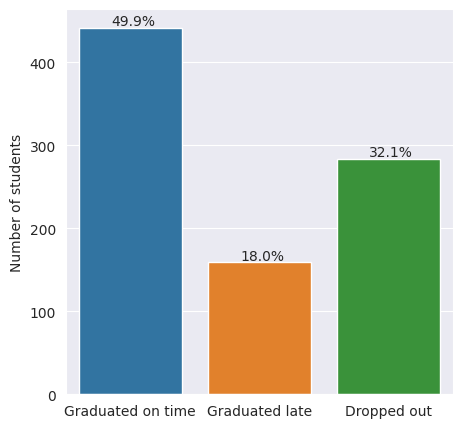

In [52]:
plt.figure(figsize=(5,5))
plot = sns.countplot(data=train, x = "Target")
plt.ylabel("Number of students")
plt.xlabel("")
plt.xticks([0, 1, 2], ['Graduated on time', 'Graduated late', 'Dropped out' ])

# annotations in percentage
total_count = train.shape[0]
for p in plot.patches:
    xy = (p.get_x() + 0.25, p.get_height()+ 3)
    percentage = p.get_height()*100/total_count
    plot.annotate(f"{percentage:.1f}%", xy)

**32% students dropped out while another 18% graduated late.**

### Course wise outcomes

<Figure size 1000x800 with 0 Axes>

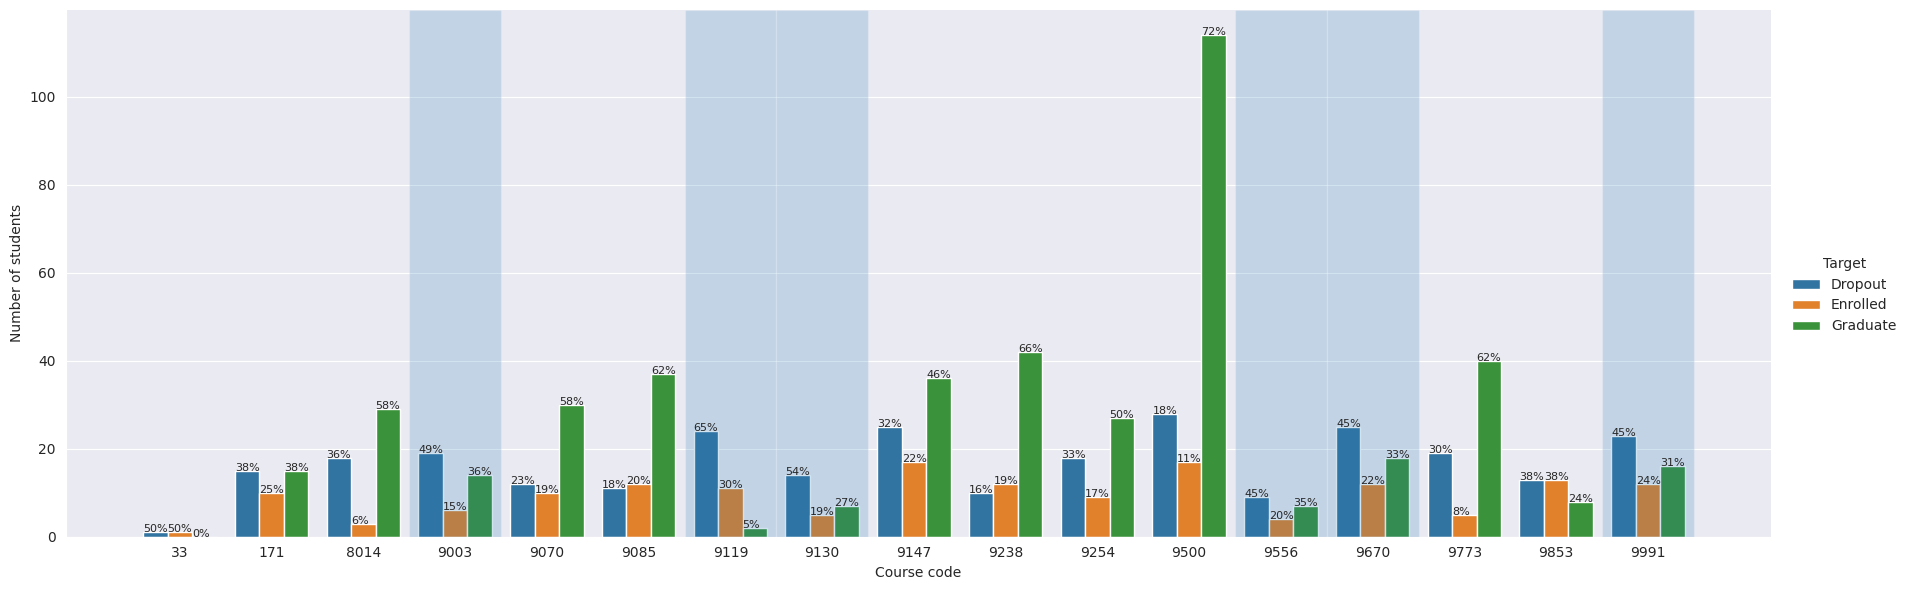

In [98]:
# Prepare the dataset for plotting
course_wise_dropout = train.groupby(["Course", "Target"]).size().reset_index().rename(columns={0:"count"})
# There is a zero count in one of the course which doesn't show up in groupby. adding it manually
missing = pd.DataFrame({"Course": 33, "Target": "Graduate", "count": 0}, index=[0])
course_wise_dropout = pd.concat((course_wise_dropout, missing)).reset_index()

#Sorting to get to the same order as groupby so that values can be assigned easily in line2
course_wise_dropout.sort_values(by=["Course", "Target"], inplace=True)
course_wise_dropout["percentage"] = course_wise_dropout.groupby("Course").apply(lambda x: x["count"]/x["count"].sum()).values

#sorting in the plotting order
course_wise_dropout.sort_values(by=["Target", "Course"], inplace=True)

# Plotting
plt.figure(figsize=(10,8))
fig = sns.catplot(data=course_wise_dropout, x="Course", y = "count", kind='bar', hue="Target", height= 6, aspect=3)
plt.xlabel("Course code")
plt.ylabel("Number of students")

# Annotation
for i, bar in enumerate(fig.ax.patches):
    percent = f"{course_wise_dropout.iloc[i, 4]*100:.0f}%"
    xy = (bar.get_x(), bar.get_height())
    fig.ax.annotate(percent, xy, fontsize=8)

#Highlighting
for x in [3, 6, 7, 12, 13, 16]:
    fig.ax.axvspan(x-0.5, x + 0.5, alpha = 0.2) 

plt.show()

__The following courses have a much higher dropout rate(45% or above) than the university average__

__* 9119 - 65% - Informatics engineering__

__* 9130 - 54% - Equinculture__

__* 9003 - 49% - Agronomy__

__* 9556 - 45% - Oral Hygiene__

__* 9670 - 45% - Advertising and marketing__

__* 9991 - 45% - Management(evening attendance)__

In [137]:
len(fig.ax.patches)


51